<a href="https://colab.research.google.com/github/OgunSerifOnargan/VBM683-MachineLearning/blob/main/SoccerEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Importing Data
*   Seperating Logs
*   Creating Sample Match


In [ ]:
#@title
from google.colab import files 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install opendatasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import opendatasets as od
import pandas
od.download("https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset")
#main datasets
logs = pd.read_csv("/content/soccer-match-event-dataset/features.csv")
logs.fillna(0,inplace=True)
logs["time_pass-0"] = logs["time_played-0"] - logs["time_played-1"]
feature_logs = logs[(logs["period_id-0"]==1) | ((logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350))]
# feature_logs = logs[(logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350)]
target_logs = logs[(logs["period_id-0"]==2) & (logs["time_seconds-0"]>1350)]
goal_logs = logs[(logs["period_id-0"]==1) | ((logs["period_id-0"]==2) & (logs["time_seconds-0"]<1350))]
sampleMatch = logs[logs["game_id-0"]==2500089]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: ognerifonargan
Your Kaggle Key: ··········


100%|██████████| 496M/496M [00:20<00:00, 24.9MB/s]


**EDA Functions**


In [ ]:
#@title
# According to event type, it creates df for each meter in x-axis

def event_df_creator_final(data, feature, val_min, val_max):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  name = (str(val_min) + " <= " + feature + " <= " + str(val_max))
  event_count = data[(data["type_name-0"]==feature) & (data["start_x-0"]<=val_max) & (data["start_x-0"]>=val_min)].groupby("game_id-0")["Unnamed: 0"].count()
  df_event_count = pd.DataFrame(event_count.values, index=event_count.index, columns=[name])
  df_final = pd.concat([df_final, df_event_count], axis=1)
  # target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  # df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])
  # result = pd.concat([df_final, df_target_corner], axis=1)
  df_final.fillna(0, inplace=True)
  return df_final


def event_df_creator(data, event, event_type):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  for i in range(1,105):
    name = (event + " < " + str(i)) 
    if event_type == "off":
      list_event = data[(data["type_name-0"]==event) & (data["start_x-0"]<=i)].groupby("game_id-0")["Unnamed: 0"].count()
    if event_type == "def":
      list_event = data[(data["type_name-0"]==event) & (data["start_x-1"]<=i)].groupby("game_id-0")["Unnamed: 0"].count()

    df_event = pd.DataFrame(list_event.values, index=list_event.index, columns=[name])
    df_final = pd.concat([df_final, df_event], axis=1)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
  
  y=df_target_corners["total_corner"]
  med_y = np.median(y)
  y[y<med_y] = 0
  y[y>=med_y] = 1

  df_eventandTargetCorners = pd.concat([df_final, df_target_corners], axis=1)
  df_eventandTargetCorners.fillna(0, inplace=True)
  return df_eventandTargetCorners

#Plotting correlation for an event and each meter of x-axis

def event_corr_plot(event, event_type):
  df_event = event_df_creator(feature_logs, event, event_type)
  event_corr = df_event.corr()
  plt.plot(range(1,105), event_corr["total_corner"].iloc[:-1])
  plt.xlabel("X-Axis")
  ylabel = event + " Corr"
  plt.ylabel(ylabel)


In [ ]:
#@title
def event_df_btw_val(data, feature, val_min, val_max):
  df_final = pd.DataFrame(index=data["game_id-0"].unique())
  for i in range(val_min, val_max):
    for j in range(val_min,i):
      name = (str(j) + " <= " + feature + " <= " + str(i))
      event_count = data[(data["type_name-0"]==feature) & (data["start_x-0"]<=i) & (data["start_x-0"]>=j)].groupby("game_id-0")["Unnamed: 0"].count()
      df_event_count = pd.DataFrame(event_count.values, index=event_count.index, columns=[name])
      df_final = pd.concat([df_final, df_event_count], axis=1)
  target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])
    
  y=df_target_corner["total_corner"]
  med_y = np.median(y)
  y[y<med_y] = 0
  y[y>=med_y] = 1

  result = pd.concat([df_final, df_target_corner], axis=1)
  result.fillna(0, inplace=True)
  return result

EDA Functions

In [ ]:
#@title
def event_analysis(event):
  display(logs[logs["type_name-0"]==event]["Unnamed: 0"].count())

  best = [0, 0]
  ratio_list = []
  for i in range(1,105):
    int_corner = logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["start_x-1"]<i) & (logs["type_name-1"]==event)]["Unnamed: 0"].count() 
    int_total = logs[(logs["type_name-1"]==event) & (logs["start_x-1"]<i)]["Unnamed: 0"].count() 
    ratio = int_corner/int_total
    ratio_list.append(ratio)
    if ratio>best[0]:
      best[0] = ratio
      best[1] = i
    print("Ratio is: " + str(ratio) + " in " + str(i))
  print(best)

  plt.plot(range(1,105), ratio_list)
  plt.xlabel("X-Axis")
  plt.ylabel(event + " Cause Corner /" + "Total " + event)
  plt.show()

  event_corr_plot(event, "off")
  plt.show()

  display(logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["type_name-1"]==event)].groupby("type_name-2")["Unnamed: 0"].count().sort_values(ascending=False))

  int_interval_detect = event_df_btw_val(feature_logs, event, 0, 106).corr()
  print(int_interval_detect[int_interval_detect.columns[-1]][:-1])
  print(min(int_interval_detect[int_interval_detect.columns[-1]][:-1]))
  print(max(int_interval_detect[int_interval_detect.columns[-1]][:-1]))



def event_analysis_off(event):
  display(logs[logs["type_name-0"]==event]["Unnamed: 0"].count())

  best = [0, 0]
  ratio_list = []
  for i in range(1,105):
    int_corner = logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & (logs["start_x-1"]<i) & ((logs["type_name-1"]==event) | (logs["type_name-2"]==event))]["Unnamed: 0"].count() 
    int_total = logs[(logs["type_name-1"]==event) & (logs["start_x-1"]<i)]["Unnamed: 0"].count() 
    ratio = int_corner/int_total
    ratio_list.append(ratio)
    if ratio>best[0]:
      best[0] = ratio
      best[1] = i
    print("Ratio is: " + str(ratio) + " in " + str(i))
  print(best)

  plt.plot(range(1,105), ratio_list)
  plt.xlabel("X-Axis")
  plt.ylabel(event + " Cause Corner /" + "Total " + event)
  plt.show()

  event_corr_plot(event, "off")
  plt.show()

  display(logs[((logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")) & ((logs["type_name-1"]==event) | (logs["type_name-2"]==event))].groupby("type_name-2")["Unnamed: 0"].count().sort_values(ascending=False))

  int_interval_detect = event_df_btw_val(feature_logs, event, 0, 106).corr()
  print(int_interval_detect[int_interval_detect.columns[-1]][:-1])
  print(min(int_interval_detect[int_interval_detect.columns[-1]][:-1]))
  print(max(int_interval_detect[int_interval_detect.columns[-1]][:-1]))

Posession Functions

In [ ]:
#@title
def pos_df_creator(x1, x2, pos_type):
  matchID = feature_logs["game_id-0"].unique()
  df_pos = pd.DataFrame(index=matchID)
  name = "POS " + str(x1) + "<" + " x " + str(x2)
  if pos_type=="time":
    df_pos [name] = feature_logs[(feature_logs["start_x-0"]>x1) & (feature_logs["start_x-0"]<=x2)].groupby("game_id-0")["time_pass-0"].sum()
  if pos_type=="count":
    df_pos [name] = feature_logs[(feature_logs["start_x-0"]>x1) & (feature_logs["start_x-0"]<=x2)].groupby("game_id-0")["time_pass-0"].count()
  df_pos.fillna(0, inplace=True)
  return df_pos

def pos_table(x1,x2, pos_type):
  matchID = feature_logs["game_id-0"].unique()
  pos_table = pd.DataFrame(index=matchID)
  for i in range(x1,x2):
    for j in range(0,i):
      if pos_type=="time":
        df_pos_game = pos_df_creator(j,i, "time")
      if pos_type=="count":
        df_pos_game = pos_df_creator(j,i, "count")
      pos_table = pd.concat([pos_table, df_pos_game], axis=1)
  return pos_table

def pos_corr_table(pos_type):
  POS = pos_table(1,106, pos_type)
  POS.fillna(0, inplace=True)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
    
  y=df_target_corners["total_corner"]
  med_y = np.median(y)
  y[y<med_y] = 0
  y[y>=med_y] = 1

  df_poss = pd.concat([POS, df_target_corners], axis=1)
  df_poss.fillna(0,inplace=True)
  df_poss_corr=df_poss.corr()
  print(df_poss_corr[df_poss_corr.columns[-1]][:-1])

Crossing Line Functions

In [ ]:
#@title
def line_df_creator(x):
  matchID = feature_logs["game_id-0"].unique()
  df_crossingLine = pd.DataFrame(index=matchID)
  name = "Crossing Line " + str(x)
  df_line = feature_logs[((feature_logs["start_x-0"]<x) & (feature_logs["end_x-0"]>x)) | ((feature_logs["start_x-0"]>x) & (feature_logs["end_x-0"]<x))]
  df_line_matches = df_line.groupby("game_id-0")["Unnamed: 0"].count()
  df_crossingLine[name] = df_line_matches
  return df_crossingLine

def line_table(x):
  matchID = feature_logs["game_id-0"].unique()
  line_table = pd.DataFrame(index=matchID)
  for i in range(1,x):
    line = line_df_creator(i)
    line_table = pd.concat([line_table, line], axis=1)
  return line_table

def line_corr_table(x):
  line = line_table(x)
  line.fillna(0, inplace=True)
  target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
  df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
    
  y=df_target_corners["total_corner"]
  med_y = np.median(y)
  y[y<med_y] = 0
  y[y>=med_y] = 1


  df_line = pd.concat([line, df_target_corners], axis=1)
  df_line.fillna(0, inplace=True)
  df_line_corr=df_line.corr()
  print(df_line_corr[df_line_corr.columns[-1]][:-1])
  return df_line_corr[df_line_corr.columns[-1]][:-1]

**EDA**

In [ ]:
# What are previous events of Corners 
preCornerEvents_count =logs[(logs["type_name-0"]=="corner_crossed") | (logs["type_name-0"]=="corner_short")].groupby("type_name-1")["Unnamed: 0"].count().sort_values(ascending=False)
preCornerEvents_count

type_name-1
interception        7458
clearance           5219
pass                3163
keeper_save         2323
tackle               458
take_on              348
cross                 98
corner_crossed        71
shot                  52
dribble               35
freekick_crossed      33
throw_in              27
freekick_short        15
corner_short           5
goalkick               5
shot_freekick          2
Name: Unnamed: 0, dtype: int64

Interception

133174

Ratio is: 0.7777777777777778 in 1
Ratio is: 0.6865203761755486 in 2
Ratio is: 0.6815352697095436 in 3
Ratio is: 0.6489193463363205 in 4
Ratio is: 0.6316330023964396 in 5
Ratio is: 0.6144247566758173 in 6
Ratio is: 0.5917610308473252 in 7
Ratio is: 0.5678168230243282 in 8
Ratio is: 0.5401401930961514 in 9
Ratio is: 0.5157918399460493 in 10
Ratio is: 0.49428431851489985 in 11
Ratio is: 0.4744092771819688 in 12
Ratio is: 0.45766463752075265 in 13
Ratio is: 0.44166969147005447 in 14
Ratio is: 0.4305470399891001 in 15
Ratio is: 0.4196921478210041 in 16
Ratio is: 0.4110417966313163 in 17
Ratio is: 0.40133899216928687 in 18
Ratio is: 0.3908696149011541 in 19
Ratio is: 0.3807801884724962 in 20
Ratio is: 0.3807801884724962 in 21
Ratio is: 0.3710051682311992 in 22
Ratio is: 0.3608143009064668 in 23
Ratio is: 0.3509019990248659 in 24
Ratio is: 0.340673271045589 in 25
Ratio is: 0.33007821330078213 in 26
Ratio is: 0.31967605695127793 in 27
Ratio is: 0.30865541643984756 in 28
Ratio is: 0.29690324135

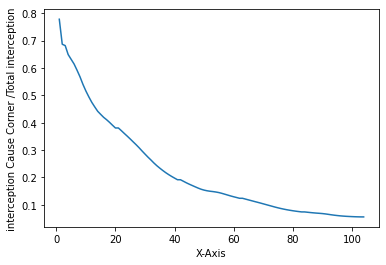

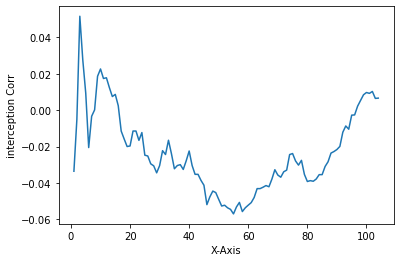

type_name-2
cross               4239
shot                2360
pass                 537
shot_freekick        123
dribble               47
corner_crossed        25
corner_short          21
freekick_crossed      20
take_on               20
clearance             18
throw_in              17
keeper_save           11
tackle                 9
interception           6
freekick_short         4
goalkick               1
Name: Unnamed: 0, dtype: int64

0 <= interception <= 1       -0.033520
0 <= interception <= 2       -0.004987
1 <= interception <= 2        0.004544
0 <= interception <= 3        0.051647
1 <= interception <= 3        0.057332
2 <= interception <= 3        0.063869
0 <= interception <= 4        0.027665
1 <= interception <= 4        0.031187
2 <= interception <= 4        0.031414
3 <= interception <= 4       -0.009379
0 <= interception <= 5        0.009419
1 <= interception <= 5        0.012053
2 <= interception <= 5        0.011261
3 <= interception <= 5       -0.020483
4 <= interception <= 5       -0.019362
0 <= interception <= 6       -0.020507
1 <= interception <= 6       -0.018415
2 <= interception <= 6       -0.019853
3 <= interception <= 6       -0.046829
4 <= interception <= 6       -0.049677
5 <= interception <= 6       -0.049320
0 <= interception <= 7       -0.003305
1 <= interception <= 7       -0.001490
2 <= interception <= 7       -0.002370
3 <= interception <= 7       -0.023395
4 <= interception <= 7   

In [ ]:
event_analysis("interception")

**Clearance**

56790

Ratio is: 0.14583333333333334 in 1
Ratio is: 0.2286902286902287 in 2
Ratio is: 0.24107142857142858 in 3
Ratio is: 0.25194981349610035 in 4
Ratio is: 0.2525354969574036 in 5
Ratio is: 0.24333474396953025 in 6
Ratio is: 0.23754031838518364 in 7
Ratio is: 0.22535438144329897 in 8
Ratio is: 0.21333333333333335 in 9
Ratio is: 0.19983277591973245 in 10
Ratio is: 0.18799059825269412 in 11
Ratio is: 0.17549578918772074 in 12
Ratio is: 0.16543950867152876 in 13
Ratio is: 0.15817086598872984 in 14
Ratio is: 0.15332714329928815 in 15
Ratio is: 0.14993093507897423 in 16
Ratio is: 0.14737120056331415 in 17
Ratio is: 0.14519832386200562 in 18
Ratio is: 0.1430581349541336 in 19
Ratio is: 0.14084390512961942 in 20
Ratio is: 0.14084390512961942 in 21
Ratio is: 0.13894981991496738 in 22
Ratio is: 0.1368230662836472 in 23
Ratio is: 0.1351429245159431 in 24
Ratio is: 0.1331357897449111 in 25
Ratio is: 0.13136593163998073 in 26
Ratio is: 0.12970051790137357 in 27
Ratio is: 0.1281096673981114 in 28
Ratio is

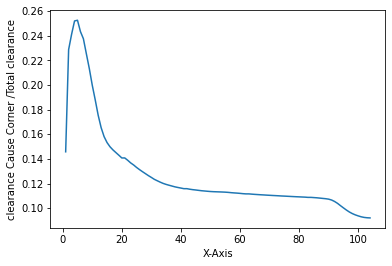

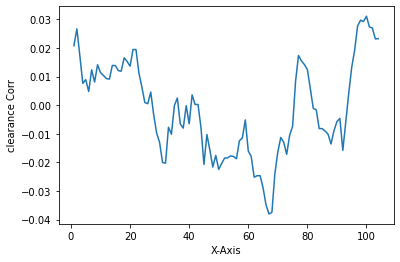

type_name-2
cross               2535
pass                1201
corner_crossed       281
freekick_crossed     265
shot                 198
dribble              176
interception         153
take_on              113
throw_in              65
corner_short          51
tackle                45
keeper_save           35
clearance             34
shot_freekick         34
freekick_short        28
goalkick               5
Name: Unnamed: 0, dtype: int64

0 <= clearance <= 1        0.020797
0 <= clearance <= 2        0.026682
1 <= clearance <= 2        0.020727
0 <= clearance <= 3        0.017358
1 <= clearance <= 3        0.011359
2 <= clearance <= 3       -0.003902
0 <= clearance <= 4        0.007628
1 <= clearance <= 4        0.001396
2 <= clearance <= 4       -0.014122
3 <= clearance <= 4       -0.018851
0 <= clearance <= 5        0.008911
1 <= clearance <= 5        0.003322
2 <= clearance <= 5       -0.009618
3 <= clearance <= 5       -0.009558
4 <= clearance <= 5        0.004669
0 <= clearance <= 6        0.004773
1 <= clearance <= 6       -0.000700
2 <= clearance <= 6       -0.013492
3 <= clearance <= 6       -0.014325
4 <= clearance <= 6       -0.003648
5 <= clearance <= 6       -0.012348
0 <= clearance <= 7        0.012367
1 <= clearance <= 7        0.007559
2 <= clearance <= 7       -0.002871
3 <= clearance <= 7       -0.000656
4 <= clearance <= 7        0.010893
5 <= clearance <= 7        0.010334
6 <= clearance <= 7        0

In [ ]:
event_analysis("clearance")

Keeper Save

12531

Ratio is: 0.47607655502392343 in 1
Ratio is: 0.4748373101952278 in 2
Ratio is: 0.47268408551068886 in 3
Ratio is: 0.4680350652127432 in 4
Ratio is: 0.46386946386946387 in 5
Ratio is: 0.4591023489932886 in 6
Ratio is: 0.4545265780730897 in 7
Ratio is: 0.450875386199794 in 8
Ratio is: 0.44728238659583164 in 9
Ratio is: 0.44231157809658517 in 10
Ratio is: 0.4388532477947073 in 11
Ratio is: 0.4358821186778176 in 12
Ratio is: 0.4338089575901704 in 13
Ratio is: 0.43133004926108376 in 14
Ratio is: 0.4304818092428712 in 15
Ratio is: 0.4301434466496365 in 16
Ratio is: 0.42929986271818005 in 17
Ratio is: 0.42871132001566786 in 18
Ratio is: 0.4275390625 in 19
Ratio is: 0.4267888477286021 in 20
Ratio is: 0.4267888477286021 in 21
Ratio is: 0.42595835765713175 in 22
Ratio is: 0.4252136752136752 in 23
Ratio is: 0.42463627546071775 in 24
Ratio is: 0.42389620449264137 in 25
Ratio is: 0.42340425531914894 in 26
Ratio is: 0.4226684688163738 in 27
Ratio is: 0.4218539217575641 in 28
Ratio is: 0.421042508174

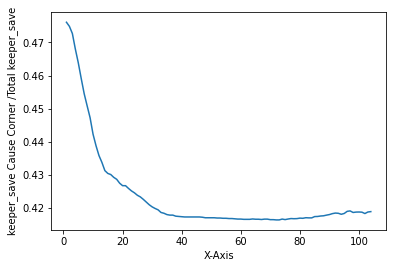

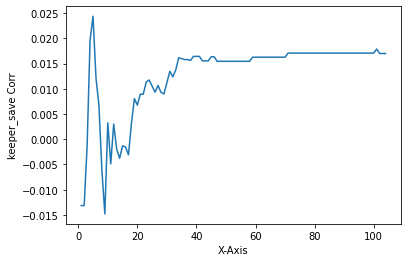

type_name-2
shot                2004
shot_freekick        155
cross                 49
interception          21
dribble               20
shot_penalty          19
clearance             16
corner_crossed        13
freekick_crossed      12
pass                  12
keeper_save            2
Name: Unnamed: 0, dtype: int64

0 <= keeper_save <= 1       -0.013145
0 <= keeper_save <= 2       -0.013158
1 <= keeper_save <= 2       -0.003902
0 <= keeper_save <= 3       -0.001350
1 <= keeper_save <= 3        0.012246
2 <= keeper_save <= 3        0.019141
0 <= keeper_save <= 4        0.019620
1 <= keeper_save <= 4        0.035089
2 <= keeper_save <= 4        0.040963
3 <= keeper_save <= 4        0.036430
0 <= keeper_save <= 5        0.024371
1 <= keeper_save <= 5        0.037054
2 <= keeper_save <= 5        0.041371
3 <= keeper_save <= 5        0.036244
4 <= keeper_save <= 5        0.014900
0 <= keeper_save <= 6        0.012171
1 <= keeper_save <= 6        0.020515
2 <= keeper_save <= 6        0.022857
3 <= keeper_save <= 6        0.016788
4 <= keeper_save <= 6       -0.003969
5 <= keeper_save <= 6       -0.019490
0 <= keeper_save <= 7        0.006724
1 <= keeper_save <= 7        0.013244
2 <= keeper_save <= 7        0.014882
3 <= keeper_save <= 7        0.009160
4 <= keeper_save <= 7       -0.009112
5 <= keeper_

In [ ]:
event_analysis("keeper_save")

SHOT

43071

<ipython-input-10-715e5a686470>:43: RuntimeWarning: divide by zero encountered in long_scalars
  ratio = int_corner/int_total


Ratio is: inf in 1
Ratio is: 224.88888888888889 in 2
Ratio is: 52.97435897435897 in 3
Ratio is: 24.318181818181817 in 4
Ratio is: 14.044025157232705 in 5
Ratio is: 9.610655737704919 in 6
Ratio is: 7.873015873015873 in 7
Ratio is: 6.342995169082125 in 8
Ratio is: 5.5452755905511815 in 9
Ratio is: 4.796825396825397 in 10
Ratio is: 4.281373844121532 in 11
Ratio is: 3.9803012746234065 in 12
Ratio is: 3.832983193277311 in 13
Ratio is: 3.601325757575758 in 14
Ratio is: 3.5621033544877605 in 15
Ratio is: 3.54070796460177 in 16
Ratio is: 3.544821583986075 in 17
Ratio is: 3.5169779286926994 in 18
Ratio is: 3.498759305210918 in 19
Ratio is: 3.4854132901134522 in 20
Ratio is: 3.4854132901134522 in 21
Ratio is: 3.4217151848937846 in 22
Ratio is: 3.3582317073170733 in 23
Ratio is: 3.2709251101321586 in 24
Ratio is: 3.209850107066381 in 25
Ratio is: 3.1430555555555557 in 26
Ratio is: 3.092391304347826 in 27
Ratio is: 3.0324718356527502 in 28
Ratio is: 2.9779364049318624 in 29
Ratio is: 2.92180546726

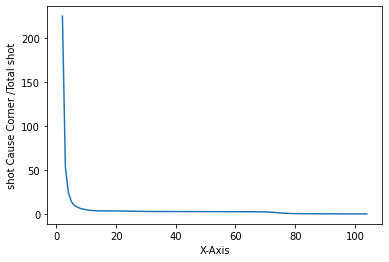

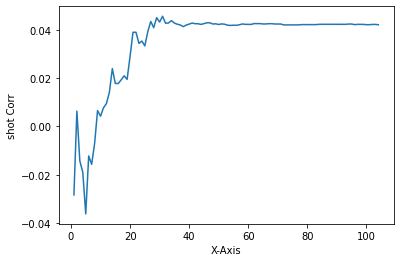

type_name-2
shot                4569
dribble               14
corner_crossed        12
cross                  6
pass                   6
interception           5
clearance              3
freekick_crossed       2
take_on                2
keeper_save            1
throw_in               1
Name: Unnamed: 0, dtype: int64

0 <= shot <= 1       -0.028382
0 <= shot <= 2        0.006365
1 <= shot <= 2        0.016718
0 <= shot <= 3       -0.014284
1 <= shot <= 3       -0.010206
2 <= shot <= 3       -0.019208
0 <= shot <= 4       -0.018974
1 <= shot <= 4       -0.016420
2 <= shot <= 4       -0.021714
3 <= shot <= 4       -0.013210
0 <= shot <= 5       -0.036246
1 <= shot <= 5       -0.034471
2 <= shot <= 5       -0.038487
3 <= shot <= 5       -0.033876
4 <= shot <= 5       -0.034127
0 <= shot <= 6       -0.012209
1 <= shot <= 6       -0.010796
2 <= shot <= 6       -0.013409
3 <= shot <= 6       -0.007923
4 <= shot <= 6       -0.002219
5 <= shot <= 6        0.028658
0 <= shot <= 7       -0.015687
1 <= shot <= 7       -0.014535
2 <= shot <= 7       -0.016666
3 <= shot <= 7       -0.012280
4 <= shot <= 7       -0.008137
5 <= shot <= 7        0.010926
6 <= shot <= 7       -0.010965
0 <= shot <= 8       -0.007074
1 <= shot <= 8       -0.006081
2 <= shot <= 8       -0.007814
3 <= shot <= 8       -0.003833
4 <= sho

In [ ]:
event_analysis_off("shot")

62326

Ratio is: 1.0384615384615385 in 1
Ratio is: 0.8888888888888888 in 2
Ratio is: 0.9743589743589743 in 3
Ratio is: 1.094896331738437 in 4
Ratio is: 1.1477987421383649 in 5
Ratio is: 1.1602638727202172 in 6
Ratio is: 1.1557727550397068 in 7
Ratio is: 1.1151560178306092 in 8
Ratio is: 1.0753496138593195 in 9
Ratio is: 1.0406045156591406 in 10
Ratio is: 0.9993519118600129 in 11
Ratio is: 0.9522058823529411 in 12
Ratio is: 0.9089428687745963 in 13
Ratio is: 0.8776711452335253 in 14
Ratio is: 0.8434508663516297 in 15
Ratio is: 0.8125578168362627 in 16
Ratio is: 0.7883415069103878 in 17
Ratio is: 0.7619965724078834 in 18
Ratio is: 0.737874097007224 in 19
Ratio is: 0.7146557736375411 in 20
Ratio is: 0.7146557736375411 in 21
Ratio is: 0.6886296260877881 in 22
Ratio is: 0.6667282297534398 in 23
Ratio is: 0.6469219756621332 in 24
Ratio is: 0.626308051543717 in 25
Ratio is: 0.6082033215903372 in 26
Ratio is: 0.592783084333415 in 27
Ratio is: 0.5789976894271373 in 28
Ratio is: 0.5665991587474685 in 2

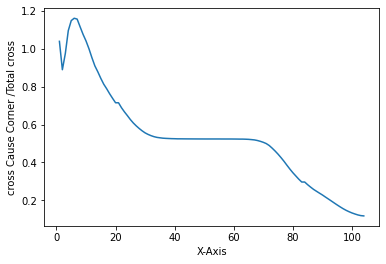

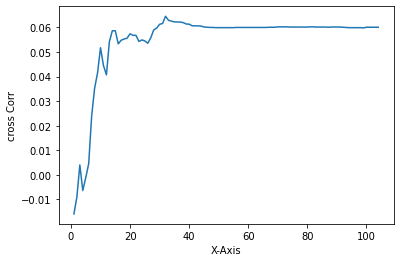

type_name-2
cross               7252
pass                  42
dribble               22
clearance             14
interception           7
take_on                3
corner_crossed         2
corner_short           2
freekick_crossed       2
freekick_short         1
keeper_save            1
throw_in               1
Name: Unnamed: 0, dtype: int64

0 <= cross <= 1       -0.015926
0 <= cross <= 2       -0.009087
1 <= cross <= 2       -0.004672
0 <= cross <= 3        0.003991
1 <= cross <= 3        0.006643
2 <= cross <= 3        0.011504
0 <= cross <= 4       -0.006397
1 <= cross <= 4       -0.004605
2 <= cross <= 4       -0.003201
3 <= cross <= 4       -0.014478
0 <= cross <= 5       -0.001177
1 <= cross <= 5        0.000302
2 <= cross <= 5        0.001881
3 <= cross <= 5       -0.004636
4 <= cross <= 5        0.007682
0 <= cross <= 6        0.004515
1 <= cross <= 6        0.005827
2 <= cross <= 6        0.007507
3 <= cross <= 6        0.003065
4 <= cross <= 6        0.013720
5 <= cross <= 6        0.012402
0 <= cross <= 7        0.023926
1 <= cross <= 7        0.025190
2 <= cross <= 7        0.027627
3 <= cross <= 7        0.025767
4 <= cross <= 7        0.037765
5 <= cross <= 7        0.041617
6 <= cross <= 7        0.047265
0 <= cross <= 8        0.035182
1 <= cross <= 8        0.036330
2 <= cross <= 8        0.038740
3 <= cro

In [ ]:
event_analysis_off("cross")

1646227

Ratio is: 0.7936507936507936 in 1
Ratio is: 0.2751798561151079 in 2
Ratio is: 0.22347514095335724 in 3
Ratio is: 0.20185449358059915 in 4
Ratio is: 0.1828278513455788 in 5
Ratio is: 0.16460587326120557 in 6
Ratio is: 0.14978711523696517 in 7
Ratio is: 0.1377232850650037 in 8
Ratio is: 0.12628601877279994 in 9
Ratio is: 0.1135035777588131 in 10
Ratio is: 0.10368360246110857 in 11
Ratio is: 0.09380606386795838 in 12
Ratio is: 0.08482724277943768 in 13
Ratio is: 0.07692435938047049 in 14
Ratio is: 0.07051815318794938 in 15
Ratio is: 0.06589015125683656 in 16
Ratio is: 0.062368347587747126 in 17
Ratio is: 0.05890731868105995 in 18
Ratio is: 0.05496555838802408 in 19
Ratio is: 0.051137724550898205 in 20
Ratio is: 0.051137724550898205 in 21
Ratio is: 0.04755928880909416 in 22
Ratio is: 0.04395521512495181 in 23
Ratio is: 0.04051273814713688 in 24
Ratio is: 0.03718031827021601 in 25
Ratio is: 0.0339938860372534 in 26
Ratio is: 0.031026294052863435 in 27
Ratio is: 0.02815952922405889 in 28
Rat

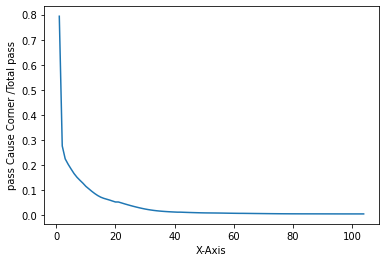

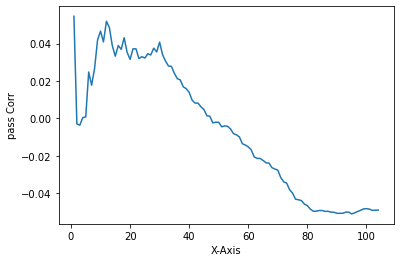

type_name-2
pass                3736
cross                399
dribble              332
interception         265
corner_crossed       227
clearance            160
throw_in             151
take_on              146
freekick_crossed     127
freekick_short        38
corner_short          29
tackle                26
keeper_save           15
goalkick              12
shot                   5
shot_penalty           1
Name: Unnamed: 0, dtype: int64

0 <= pass <= 1        0.054677
0 <= pass <= 2       -0.003001
1 <= pass <= 2       -0.020405
0 <= pass <= 3       -0.003680
1 <= pass <= 3       -0.013381
2 <= pass <= 3       -0.002507
0 <= pass <= 4        0.000407
1 <= pass <= 4       -0.006223
2 <= pass <= 4        0.001849
3 <= pass <= 4        0.004442
0 <= pass <= 5        0.000715
1 <= pass <= 5       -0.004453
2 <= pass <= 5        0.001817
3 <= pass <= 5        0.003427
4 <= pass <= 5        0.000722
0 <= pass <= 6        0.024804
1 <= pass <= 6        0.020694
2 <= pass <= 6        0.027183
3 <= pass <= 6        0.030965
4 <= pass <= 6        0.035545
5 <= pass <= 6        0.049724
0 <= pass <= 7        0.017717
1 <= pass <= 7        0.014153
2 <= pass <= 7        0.019302
3 <= pass <= 7        0.021645
4 <= pass <= 7        0.022823
5 <= pass <= 7        0.026693
6 <= pass <= 7       -0.007308
0 <= pass <= 8        0.026813
1 <= pass <= 8        0.023779
2 <= pass <= 8        0.028488
3 <= pass <= 8        0.030961
4 <= pas

In [ ]:
event_analysis_off("pass")

194477

Ratio is: 0.03146853146853147 in 1
Ratio is: 0.04688763136620857 in 2
Ratio is: 0.06854009595613433 in 3
Ratio is: 0.08653846153846154 in 4
Ratio is: 0.08218639402280771 in 5
Ratio is: 0.07424199489940493 in 6
Ratio is: 0.06077681626081707 in 7
Ratio is: 0.05249343832020997 in 8
Ratio is: 0.04457619675010979 in 9
Ratio is: 0.03813229571984436 in 10
Ratio is: 0.03380681818181818 in 11
Ratio is: 0.03004706166284542 in 12
Ratio is: 0.028121186395712844 in 13
Ratio is: 0.026101921789846067 in 14
Ratio is: 0.024417069951605808 in 15
Ratio is: 0.02331318613543851 in 16
Ratio is: 0.02242274029896987 in 17
Ratio is: 0.021495565855260756 in 18
Ratio is: 0.020592995626571162 in 19
Ratio is: 0.01947081003770641 in 20
Ratio is: 0.01947081003770641 in 21
Ratio is: 0.01859808494966855 in 22
Ratio is: 0.01771829927450357 in 23
Ratio is: 0.016853167796564022 in 24
Ratio is: 0.016034123904720303 in 25
Ratio is: 0.015133201179712808 in 26
Ratio is: 0.01433341662312882 in 27
Ratio is: 0.01349446982961096

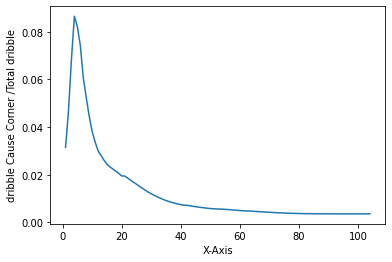

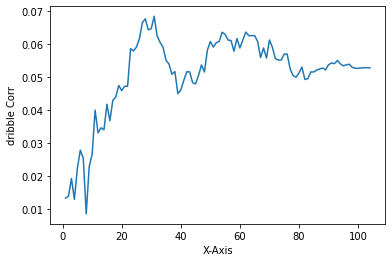

type_name-2
dribble     644
pass         29
cross         3
shot          2
goalkick      1
Name: Unnamed: 0, dtype: int64

0 <= dribble <= 1        0.013289
0 <= dribble <= 2        0.013904
1 <= dribble <= 2        0.004858
0 <= dribble <= 3        0.019209
1 <= dribble <= 3        0.015284
2 <= dribble <= 3        0.017157
0 <= dribble <= 4        0.012910
1 <= dribble <= 4        0.005017
2 <= dribble <= 4        0.003545
3 <= dribble <= 4       -0.008080
0 <= dribble <= 5        0.022274
1 <= dribble <= 5        0.017791
2 <= dribble <= 5        0.017637
3 <= dribble <= 5        0.012734
4 <= dribble <= 5        0.023494
0 <= dribble <= 6        0.027820
1 <= dribble <= 6        0.024588
2 <= dribble <= 6        0.024662
3 <= dribble <= 6        0.021432
4 <= dribble <= 6        0.028843
5 <= dribble <= 6        0.018508
0 <= dribble <= 7        0.025341
1 <= dribble <= 7        0.021647
2 <= dribble <= 7        0.021455
3 <= dribble <= 7        0.018656
4 <= dribble <= 7        0.023348
5 <= dribble <= 7        0.014976
6 <= dribble <= 7        0.004103
0 <= dribble <= 8        0.008494
1 <= dribble <

In [ ]:
event_analysis_off("dribble")

EDA: POSESSIONS TIME

In [ ]:
pos_corr_table("time")

POS 0< x 1             NaN
POS 0< x 2       -0.036283
POS 1< x 2       -0.036283
POS 0< x 3       -0.048745
POS 1< x 3       -0.048745
POS 2< x 3       -0.035785
POS 0< x 4       -0.028690
POS 1< x 4       -0.028690
POS 2< x 4       -0.016291
POS 3< x 4        0.009279
POS 0< x 5       -0.020445
POS 1< x 5       -0.020445
POS 2< x 5       -0.009967
POS 3< x 5        0.009819
POS 4< x 5        0.004847
POS 0< x 6        0.009701
POS 1< x 6        0.009701
POS 2< x 6        0.019514
POS 3< x 6        0.038126
POS 4< x 6        0.040136
POS 5< x 6        0.048919
POS 0< x 7        0.005206
POS 1< x 7        0.005206
POS 2< x 7        0.012932
POS 3< x 7        0.026509
POS 4< x 7        0.025739
POS 5< x 7        0.026743
POS 6< x 7       -0.005097
POS 0< x 8        0.010402
POS 1< x 8        0.010402
POS 2< x 8        0.016875
POS 3< x 8        0.027904
POS 4< x 8        0.027087
POS 5< x 8        0.027624
POS 6< x 8        0.005707
POS 7< x 8        0.012666
POS 0< x 9        0.037962
P

EDA: POSESSIONS EVENT COUNT

In [ ]:
pos_corr_table("count")

POS 0< x 1             NaN
POS 0< x 2       -0.011737
POS 1< x 2       -0.011737
POS 0< x 3        0.001364
POS 1< x 3        0.001364
POS 2< x 3        0.009656
POS 0< x 4       -0.002595
POS 1< x 4       -0.002595
POS 2< x 4        0.001659
POS 3< x 4       -0.005608
POS 0< x 5       -0.000562
POS 1< x 5       -0.000562
POS 2< x 5        0.002779
POS 3< x 5       -0.001680
POS 4< x 5        0.002758
POS 0< x 6        0.017143
POS 1< x 6        0.017143
POS 2< x 6        0.020995
POS 3< x 6        0.020252
POS 4< x 6        0.028818
POS 5< x 6        0.039449
POS 0< x 7        0.021100
POS 1< x 7        0.021100
POS 2< x 7        0.024375
POS 3< x 7        0.024033
POS 4< x 7        0.030786
POS 5< x 7        0.036422
POS 6< x 7        0.016950
POS 0< x 8        0.026890
POS 1< x 8        0.026890
POS 2< x 8        0.029765
POS 3< x 8        0.029939
POS 4< x 8        0.035792
POS 5< x 8        0.040683
POS 6< x 8        0.027774
POS 7< x 8        0.024727
POS 0< x 9        0.046448
P

EDA: Crossing Line

Crossing Line 1      0.029924
Crossing Line 2      0.031762
Crossing Line 3      0.031948
Crossing Line 4      0.036521
Crossing Line 5      0.039489
Crossing Line 6      0.051734
Crossing Line 7      0.056998
Crossing Line 8      0.052886
Crossing Line 9      0.064227
Crossing Line 10     0.064998
Crossing Line 11     0.071784
Crossing Line 12     0.071804
Crossing Line 13     0.080158
Crossing Line 14     0.074066
Crossing Line 15     0.074042
Crossing Line 16     0.084291
Crossing Line 17     0.092952
Crossing Line 18     0.100462
Crossing Line 19     0.090680
Crossing Line 20     0.100165
Crossing Line 21     0.092010
Crossing Line 22     0.091328
Crossing Line 23     0.090638
Crossing Line 24     0.088008
Crossing Line 25     0.084573
Crossing Line 26     0.077573
Crossing Line 27     0.082147
Crossing Line 28     0.080236
Crossing Line 29     0.064265
Crossing Line 30     0.065832
Crossing Line 31     0.060523
Crossing Line 32     0.051832
Crossing Line 33     0.038851
Crossing L

Text(0, 0.5, 'Crossing Line Corr')

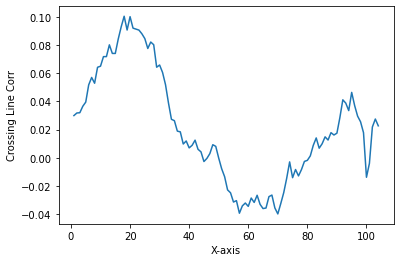

In [ ]:

line_corr = line_corr_table(105)
plt.plot(range(1,105), line_corr)
plt.xlabel("X-axis")
plt.ylabel("Crossing Line Corr")

EDA: GOALS

In [ ]:
matchID = feature_logs["game_id-0"].unique()
goals_df = pd.DataFrame(index=matchID, columns=["goals"])
goals_diff_df = pd.DataFrame(index=matchID, columns=["goals_diff"])
for i, val in enumerate(matchID):
  game = feature_logs[feature_logs["game_id-0"] == val]

  goals_home = len(game[((game["type_name-0"]=="shot_freekick") | (game["type_name-0"]=="shot") | (game["type_name-0"]=="shot_penalty")) & 
                        (game["result_name-0"]=="success") & (game["team_id-0"] == game["team_id-0"].unique()[0])])

  goals_away = len(game[((game["type_name-0"]=="shot_freekick") | (game["type_name-0"]=="shot") | 
                        (game["type_name-0"]=="shot_penalty")) & (game["result_name-0"]=="success") & 
                        (game["team_id-0"] == game["team_id-0"].unique()[1])])
  goals = goals_home + goals_away
  goals_diff = abs(goals_home - goals_away)
  goals_df["goals"][val] = goals
  goals_diff_df["goals_diff"][val] = goals_diff

target_corners = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_target_corners = pd.DataFrame(target_corners.values, index=target_corners.index, columns=["total_corner"])
y=df_target_corners["total_corner"]
med_y = np.median(y)
y[y<med_y] = 0
y[y>=med_y] = 1

goal_df = pd.concat([goals_df, goals_diff_df, df_target_corners], axis=1)
goal_df.fillna(0, inplace=True)
goal_df_final = goal_df.drop("total_corner", axis=1)
df_goal_corr=goal_df.corr()
print(df_goal_corr[df_goal_corr.columns[-1]][:-1])

goals        -0.042356
goals_diff   -0.080731
Name: total_corner, dtype: float64


CREATING DATAFRAME

Conclusion:
  Defensive Events:
    Interception
      40-46    : -0.065
      80-100   :  0.102
    Clearance
      22-31    : -0.062
      93-97    :  0.079
  Offensive Events:
    Shot
      12-31    :  0.101
    Pass
      52-67    : -0.095
      4-18     :  0.077
    Dribbling
      4-31     :  0.105
  Posessions:
    Time
      36-94    : -0.106
      4-34     :  0.082
    Event Count
      47-82    : -0.091
      4-21     :  0.106
  Crossing Line
    In and Out
      18       :  0.145
  Goals Total  : -0.0335
  Goals_Diff   : -0.0735
   
  
  

In [ ]:
df_final = pd.DataFrame(index=logs["game_id-0"].unique())

#EVENTS
interception_1 = event_df_creator_final(feature_logs,"interception", 40, 46)
interception_2 = event_df_creator_final(feature_logs,"interception", 83, 100)

clearance_1 = event_df_creator_final(feature_logs, "clearance", 22, 31)
clearance_2 = event_df_creator_final(feature_logs, "clearance", 92, 98)

shot_1 = event_df_creator_final(feature_logs, "shot", 19, 22)

keeper_save_1 = event_df_creator_final(feature_logs, "keeper_save", 0, 4)
keeper_save_2 = event_df_creator_final(feature_logs, "keeper_save", 5, 9)
keeper_save_3 = event_df_creator_final(feature_logs, "keeper_save", 17, 19)

pass_1 = event_df_creator_final(feature_logs, "pass", 53, 90)
pass_2 = event_df_creator_final(feature_logs, "pass", 0, 12)

dribbling_1 = event_df_creator_final(feature_logs, "dribble", 8, 28)

#POSESSIONS
pos_time_1 = pos_df_creator(34, 94, "time")
pos_time_2 = pos_df_creator(3, 34, "time")
pos_time_3 = pos_df_creator(94, 100, "time")
pos_time_4 = pos_time_2["POS 3< x 34"] + pos_time_3["POS 94< x 100"]

pos_count_1 = pos_df_creator(4, 30, "count")
pos_count_2 = pos_df_creator(49, 82, "count")
pos_count_3 = pos_df_creator(95, 100, "count")
pos_count_4 = pos_count_1["POS 4< x 30"] + pos_count_3["POS 95< x 100"]

#CROSSING LINE
crossing_line_1 = line_df_creator(18)

#GOALS
goals = goal_df_final

realized_corner = feature_logs[(feature_logs["type_name-0"]=="corner_crossed") | (feature_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_realized_corner = pd.DataFrame(realized_corner.values, index=realized_corner.index, columns=["realized_corner"])

target_corner = target_logs[(target_logs["type_name-0"]=="corner_crossed") | (target_logs["type_name-0"]=="corner_short")].groupby("game_id-0")["Unnamed: 0"].count()
df_target_corner = pd.DataFrame(target_corner.values, index=target_corner.index, columns=["total_corner"])

y=df_target_corner["total_corner"]
med_y = np.median(y)
y[y<med_y] = 0
y[y>=med_y] = 1

df_final = pd.concat([interception_1, interception_2, clearance_1, clearance_2, shot_1, keeper_save_1, keeper_save_2, keeper_save_3, pass_1, pass_2, 
                      dribbling_1, pos_time_1, pos_time_2, pos_time_3, pos_time_4, pos_count_1, pos_count_2, pos_count_3, 
                      pos_count_4, crossing_line_1, goals, df_realized_corner, df_target_corner], axis=1)
df_final.fillna(0, inplace=True)

In [ ]:
df_final.corr()[-1:][::]

,40 <= interception <= 46,83 <= interception <= 100,22 <= clearance <= 31,92 <= clearance <= 98,19 <= shot <= 22,0 <= keeper_save <= 4,5 <= keeper_save <= 9,17 <= keeper_save <= 19,53 <= pass <= 90,0 <= pass <= 12,8 <= dribble <= 28,POS 34< x 94,POS 3< x 34,POS 94< x 100,0,POS 4< x 30,POS 49< x 82,POS 95< x 100,1,Crossing Line 18,goals,goals_diff,realized_corner,total_corner
total_corner,-0.077241,0.08805,-0.066024,0.060254,0.079284,0.01962,-0.045196,0.054564,-0.078017,0.051993,0.071204,-0.081934,0.064543,0.075664,0.095965,0.070677,-0.073754,0.071673,0.082426,0.100462,-0.042356,-0.080731,0.014706,1.0


Text(0, 0.5, 'total_corner')

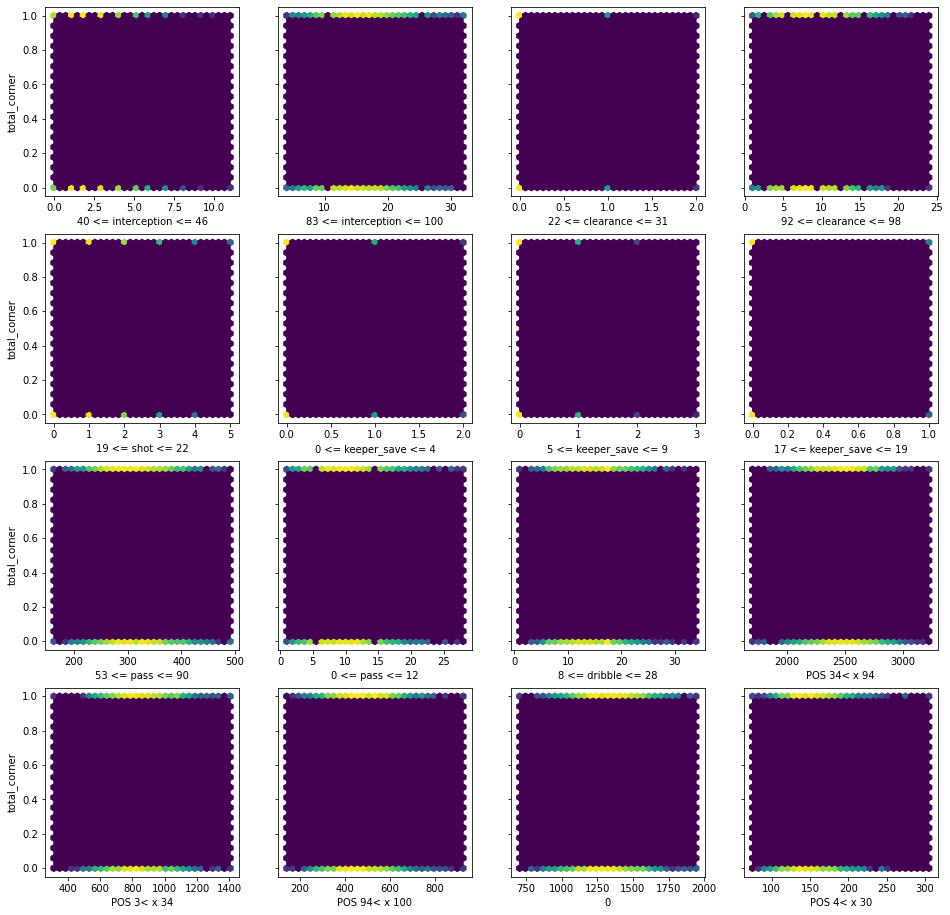

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(16, 16), sharey=True)
for i in range(0,16):
    ax[i//4, i%4].hexbin(x=df_final[df_final.columns[i]], y=df_final["total_corner"], gridsize=30, bins="log")
    ax[i//4, i%4].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")

Text(0, 0.5, 'total_corner')

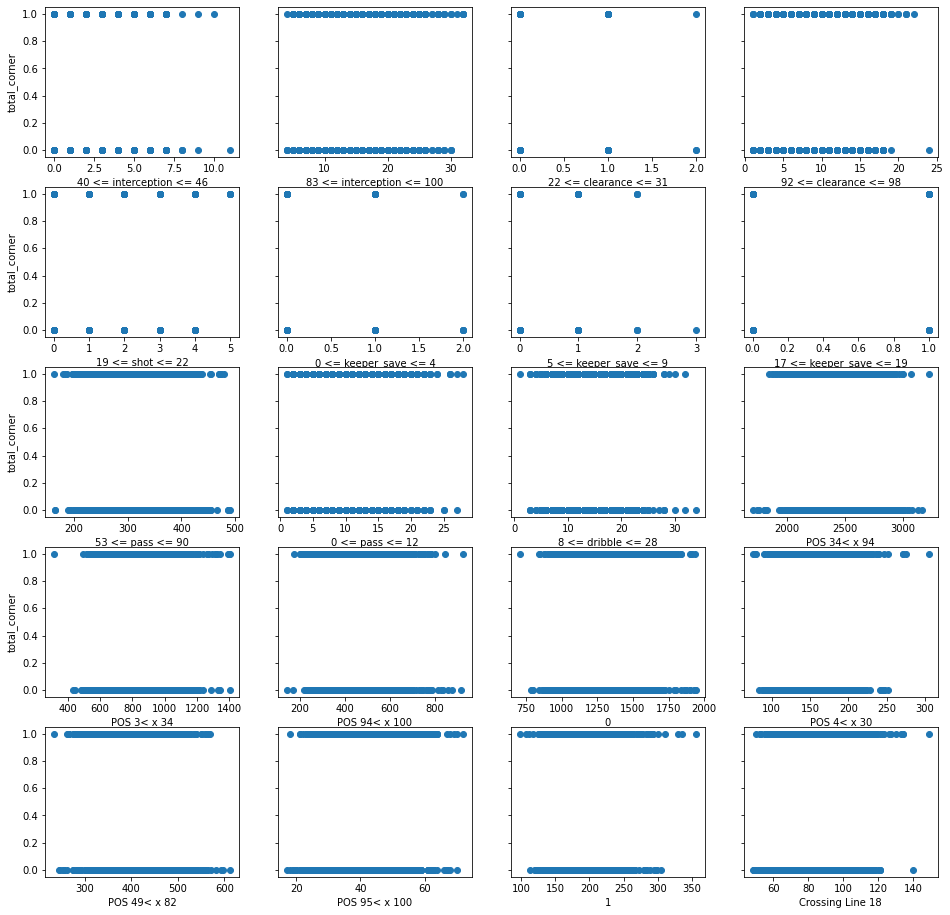

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(16, 16), sharey=True)
for i in range(0,20):
    ax[i//4, i%4].scatter(x=df_final[df_final.columns[i]], y=df_final["total_corner"])
    ax[i//4, i%4].set_xlabel(df_final.columns[i])
ax[0,0].set_ylabel("total_corner")
ax[1,0].set_ylabel("total_corner")
ax[2,0].set_ylabel("total_corner")
ax[3,0].set_ylabel("total_corner")